In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Suppress warnings for non-invertible MA parameters
warnings.filterwarnings("ignore", message="Non-invertible starting MA parameters found.")

# Loading the data
data = pd.read_excel('/Users/tegairedje/Documents/Bayes Mathematical Trading & Finance/Term 1/Asset Pricing/FTSE100 Data.xlsx', 'Sheet1')

# Converting Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Setting Date as the index
data.set_index('Date', inplace=True)

# Resample FTSE100 return into 6-month intervals and calculate cumulative returns
ftse_6m = data['FTSE 100 Return'].resample('6ME').apply(lambda x: (1 + x).prod() - 1)

# Adjusting the risk-free rate for a 6-month interval
risk_free_6m = data['UK 1M Gilt Yield'].resample('6ME').mean() / 2

# Aggregating the data into a tabulated form in the DataFrame
aggregated_data = pd.DataFrame({'FTSE 6M Return': ftse_6m, 'Risk-Free 6M Return': risk_free_6m})

#-----------------------------------------------------------------------------------------------------------#
# Creating an empty list to store the results of the forecast
investment_results = []

# Looping through the data to forecast FTSE 6-month returns for every 6 months starting from 2014-10
for end_date in aggregated_data.index[aggregated_data.index >= '2014-10-31']:
    # Use data up to the current forecast date for training
    train_data = aggregated_data.loc[:end_date, 'FTSE 6M Return']
    
    # Check if there is enough data for ARIMA to run (at least 3 data points)
    if len(train_data) < 3:
        continue  # Skip this iteration if there's insufficient data

    # Fit ARIMA model
    try:
        model = ARIMA(train_data, order=(1, 1, 1))  # ARIMA(p=1, d=1, q=1)
        model_fit = model.fit()
        
        # Forecast the next period
        forecast = model_fit.forecast(steps=1).iloc[0]

        # Comparing the forecasted return with the risk-free rate/UK Gilt Yield
        risk_free_return = aggregated_data.loc[end_date, 'Risk-Free 6M Return']
        decision = 'Invest in FTSE 100' if forecast > risk_free_return else 'Invest in Risk-Free Asset'

        # Storing the results
        investment_results.append({
            'Date': end_date,
            'Forecasted Return': forecast,
            'Risk-Free Return': risk_free_return,
            'Decision': decision
        })
    except Exception as e:
        print(f"ARIMA model failed for {end_date}: {e}")
        continue  # Skip iteration if ARIMA fails for this date

#-----------------------------------------------------------------------------------------------------------#
# Converting the results into a DataFrame
results_df = pd.DataFrame(investment_results)

# Calculate cumulative returns for the strategy
results_df['Strategy Return'] = results_df.apply(
    lambda row: row['Forecasted Return'] if row['Decision'] == 'Invest in FTSE 100' else row['Risk-Free Return'], axis=1
)
results_df['Cumulative Return'] = (1 + results_df['Strategy Return']).cumprod() - 1

# Display the results
print(results_df)

         Date  Forecasted Return  Risk-Free Return                   Decision  \
0  2014-11-30           0.017018          0.001695         Invest in FTSE 100   
1  2015-05-31           0.023434          0.001873         Invest in FTSE 100   
2  2015-11-30           0.009567          0.002015         Invest in FTSE 100   
3  2016-05-31           0.006823          0.001928         Invest in FTSE 100   
4  2016-11-30           0.018338          0.001175         Invest in FTSE 100   
5  2017-05-31           0.035933          0.000675         Invest in FTSE 100   
6  2017-11-30           0.015959          0.001168         Invest in FTSE 100   
7  2018-05-31           0.022138          0.001808         Invest in FTSE 100   
8  2018-11-30           0.014265          0.003345         Invest in FTSE 100   
9  2019-05-31           0.015017          0.003187         Invest in FTSE 100   
10 2019-11-30           0.015596          0.003742         Invest in FTSE 100   
11 2020-05-31           0.00

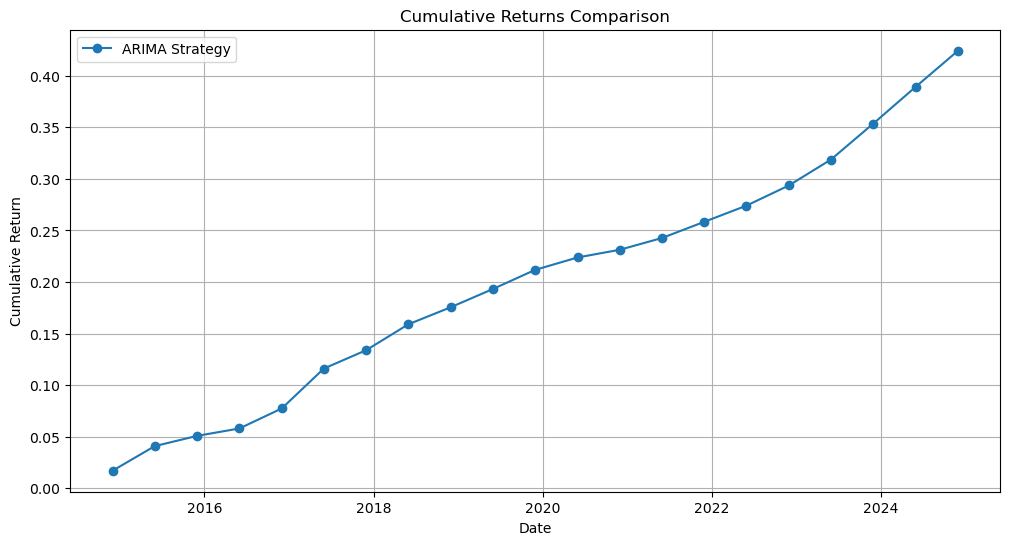

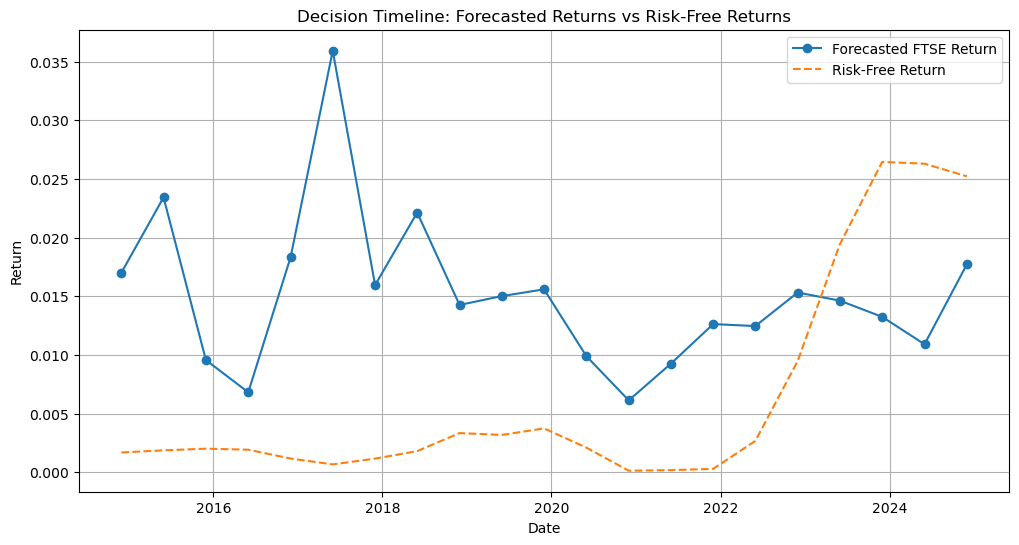

In [5]:
#------------------------------------------------------------------------------#
import matplotlib.pyplot as plt
import pandas as pd

# Use the DataFrame provided in the example
data = {
    'Date': [
        '2014-11-30', '2015-05-31', '2015-11-30', '2016-05-31', '2016-11-30',
        '2017-05-31', '2017-11-30', '2018-05-31', '2018-11-30', '2019-05-31',
        '2019-11-30', '2020-05-31', '2020-11-30', '2021-05-31', '2021-11-30',
        '2022-05-31', '2022-11-30', '2023-05-31', '2023-11-30', '2024-05-31',
        '2024-11-30'
    ],
    'Forecasted Return': [
        0.017018, 0.023434, 0.009567, 0.006823, 0.018338, 0.035933, 0.015959,
        0.022138, 0.014265, 0.015017, 0.015596, 0.009897, 0.006133, 0.009258,
        0.012635, 0.012465, 0.015326, 0.014632, 0.013250, 0.010917, 0.017726
    ],
    'Risk-Free Return': [
        0.001695, 0.001873, 0.002015, 0.001928, 0.001175, 0.000675, 0.001168,
        0.001808, 0.003345, 0.003187, 0.003742, 0.002104, 0.000136, 0.000186,
        0.000297, 0.002680, 0.009489, 0.019428, 0.026458, 0.026306, 0.025227
    ],
    'Cumulative Return': [
        0.017018, 0.040851, 0.050809, 0.057978, 0.077380, 0.116093, 0.133904,
        0.159006, 0.175539, 0.193193, 0.211802, 0.223794, 0.231299, 0.242699,
        0.258401, 0.274087, 0.293613, 0.318746, 0.353637, 0.389246, 0.424292
    ]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Cumulative Return'], label='ARIMA Strategy', marker='o')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

# Plot decision timeline
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Forecasted Return'], label='Forecasted FTSE Return', marker='o')
plt.plot(df['Date'], df['Risk-Free Return'], label='Risk-Free Return', linestyle='--')
plt.title('Decision Timeline: Forecasted Returns vs Risk-Free Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()
